Code from here: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

https://machinelearningmastery.com/how-to-load-visualize-and-explore-a-complex-multivariate-multistep-time-series-forecasting-dataset/

# load

Our focus will be the ‘TrainingData.csv‘ that contains the training dataset, specifically data in chunks where each chunk is eight contiguous days of observations and target variables.

The test dataset (remaining three days of each chunk) is not available for this dataset at the time of writing.

Open the ‘TrainingData.csv‘ file and review the contents. The unzipped data file is relatively small (21 megabytes) and will easily fit into RAM.

Reviewing the contents of the file, we can see that the data file contains a header row.

We can also see that missing data is marked with the ‘NA‘ value, which Pandas will automatically convert to NumPy.NaN.

We can see that the ‘weekday‘ column contains the day as a string, whereas all other data is numeric.

In [17]:
import pandas as pd

dataset = pd.read_csv('./data/kaggle_pollution/dsg-hackathon/TrainingData.csv', header=0)
dataset = dataset.iloc[:, 6:]
dataset.shape

(37821, 89)

We can also get a quick idea of how much missing data there is in the dataset. We can do that by first trimming the first few columns to remove the string weekday data and convert the remaining columns to floating point values.

In [18]:
# load dataset
import numpy as np
dataset = pd.read_csv('./data/kaggle_pollution/dsg-hackathon/TrainingData.csv', header=0)
# summarize
print(dataset.shape)
# trim and transform to floats
values = dataset.values
data = values[:, 6:].astype('float32')

# summarize amount of missing data
total_missing = np.count_nonzero(np.isnan(data))
percent_missing = total_missing / data.size * 100
print('Total Missing: %d/%d (%.1f%%)' % (total_missing, data.size, percent_missing))

(37821, 95)
Total Missing: 1922092/3366069 (57.1%)


Running the example first prints the shape of the loaded dataset.

We can see that we have about 37,000 rows and 95 columns. We know these numbers are misleading given that the data is in fact divided into chunks and the columns are divided into the same observations at different sites.

We can also see that a little over 40% of the data is missing. This is a lot. The data is very patchy and we are going to have to understand this well before modeling the problem.

### Chunks investigation
The data consist of hourly measurements of various quantities (mostly are pollutants), where each row contains the measurements for one hour. Time slices ("chunks") of 11 days have been created, with the first 8 days of each chunk available in the training data. You are asked to make pdictions about various points within the following 3 days (1, 2 ,3, 4, 5, 10, 17, 24, 48, and 72 hours after the end of the 8-day training data).

In [23]:
dataset =  dataset.sort_values(by='chunkID')
# total number of chunks 
len(dataset['chunkID'].unique())

208

A box and whisker plot and a histogram plot of chunk durations is created. We can see that indeed the median is 192, meaning that most chunks have eight days of observations or close to it.

We can also see a long tail of durations down to about 25 rows. Although there are not many of these cases, we would expect that will be challenging to forecast given the lack of data.

The distribution also raises questions about how contiguous the observations within each chunk may be.

Each row corresponds to one hourly measurement point.

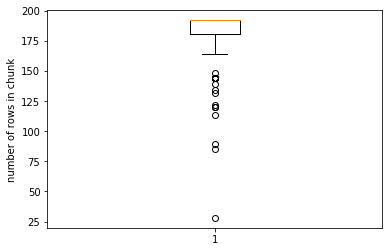

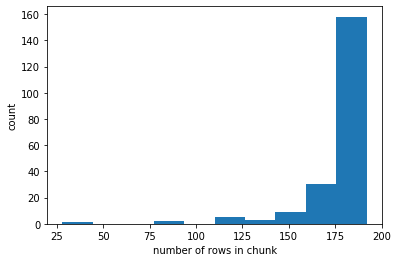

In [31]:
import matplotlib.pyplot as plt

def compute_chunk_number_of_hours(df):
    return len(df)

chunk_length = dataset.groupby('chunkID').apply(lambda x: compute_chunk_number_of_hours(x))

plt.boxplot(chunk_length)
plt.ylabel('number of rows in chunk')
plt.show()


plt.hist(chunk_length)
plt.xlabel('number of rows in chunk')
plt.ylabel('count')
plt.show()

#### Chunk Contiguousness
It may be helpful to get an idea of how contiguous (or not) the observations are within those chunks that do not have the full eight days of data.

One approach to considering this is to create a line plot for each discontiguous chunk and show the gaps in the observations.

We can do this on a single plot. Each chunk has a unique identifier, from 1 to 208, and we can use this as the value for the series and mark missing observations within the eight day interval via NaN values that will not appear on the plot.

Inverting this, we can assume that we have NaN values for all time steps within a chunk, then use the ‘position_within_chunk‘ column (index 2) to determine the time steps that do have values and mark them with the chunk id.

The plot_discontinuous_chunks() below implements this behavior, creating one series or line for each chunk with missing rows all on the same plot. The expectation is that breaks in the line will help us see how contiguous or discontiguous these incomplete chunks happen to be.